# Block segmentation and text extraction
# detect and isolate text regions in an image.


Les résultats de l'OCR dépendent de l'analyse de la mise en page. Sur la base de l'analyse de la mise en page, nous pouvons effectuer une segmentation d'image en unités logiques plus petites sous forme de blocs de texte et de lignes individuels qui sont l'entrée dans un moteur OCR. L'ensemble du processus est décomposé en trois tâches principales : la segmentation par blocs, la segmentation par ligne et la reconnaissance optique de caractères elle-même, comme illustré sur cette figure.

<img src="image\image_1.PNG" width="800"/>

l'objectif de cet article est de détecter et isoler les zones de texte dans une image.Le but de la segmentation par blocs est d'extraire des régions de texte par rapport à l'ordre de lecture. (Un ensemble ordonné de régions d'image contenant du texte est la sortie.) 
je vais vous présenter deux approche simple:
1.  La première approche consiste à obtenir une image binaire et à effectuer des opérations morphologiques pour relier le texte en un seul contour.

2. L'autre approche consiste à utiliser un algorithme de clustering pour regrouper les zones de texte.

## Détection de block de texte avec OpenCV
Le package OpenCV est utilisé pour lire une image et effectuer certaines techniques de traitement d'image.
### Installations requises :
    pip installer opencv-python
Après les importations nécessaires, un exemple d'image est lu à l'aide de la imread fonction opencv.

In [1]:
# Import required packages
import cv2
# Read image from which text needs to be extracted
img = cv2.imread(r'C:\DEV\Table_Detection\data\fact230001-1.png')

### Application du traitement d'image pour l'image :
#### Convertir l'image en niveaux de gris


In [3]:
# Convert the image to gray scale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#### Le seuillage

Il existe 3 types de seuillage :

Seuil simple
Seuil adaptatif
Binarisation d'Otsu

cv2.threshold() a 4 paramètres, le premier paramètre étant l'image modifiée dans l'espace colorimétrique, suivi de la valeur seuil minimale, de la valeur seuil maximale et du type de seuillage qui doit être appliqué.

In [4]:
# Performing OTSU threshold
ret, thresh1 = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)

#### obtenir une structure rectangulaire :

Pour obtenir une structure rectangulaire :
cv2.getStructuringElement()est utilisé pour définir un élément structurel comme elliptique, circulaire, rectangulaire etc. Ici, nous utilisons l'élément structurel rectangulaire ( cv2.MORPH_RECT). cv2.getStructuring Element prend une taille supplémentaire du paramètre du noyau . Un noyau plus gros permettrait de regrouper des blocs de textes plus gros. Après avoir choisi le bon noyau, la dilatation est appliquée à l'image avec cv2.dilatefonction. La dilatation rend les groupes de texte à détecter plus précisément car elle dilate (élargit) un bloc de texte.

In [20]:
# Specify structure shape and kernel size. 
# Kernel size increases or decreases the area 
# of the rectangle to be detected.
# A smaller value like (10, 10) will detect 
# each word instead of a sentence.
rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (20, 30))
# Appplying dilation on the threshold image
dilation = cv2.dilate(thresh1, rect_kernel, iterations = 1)

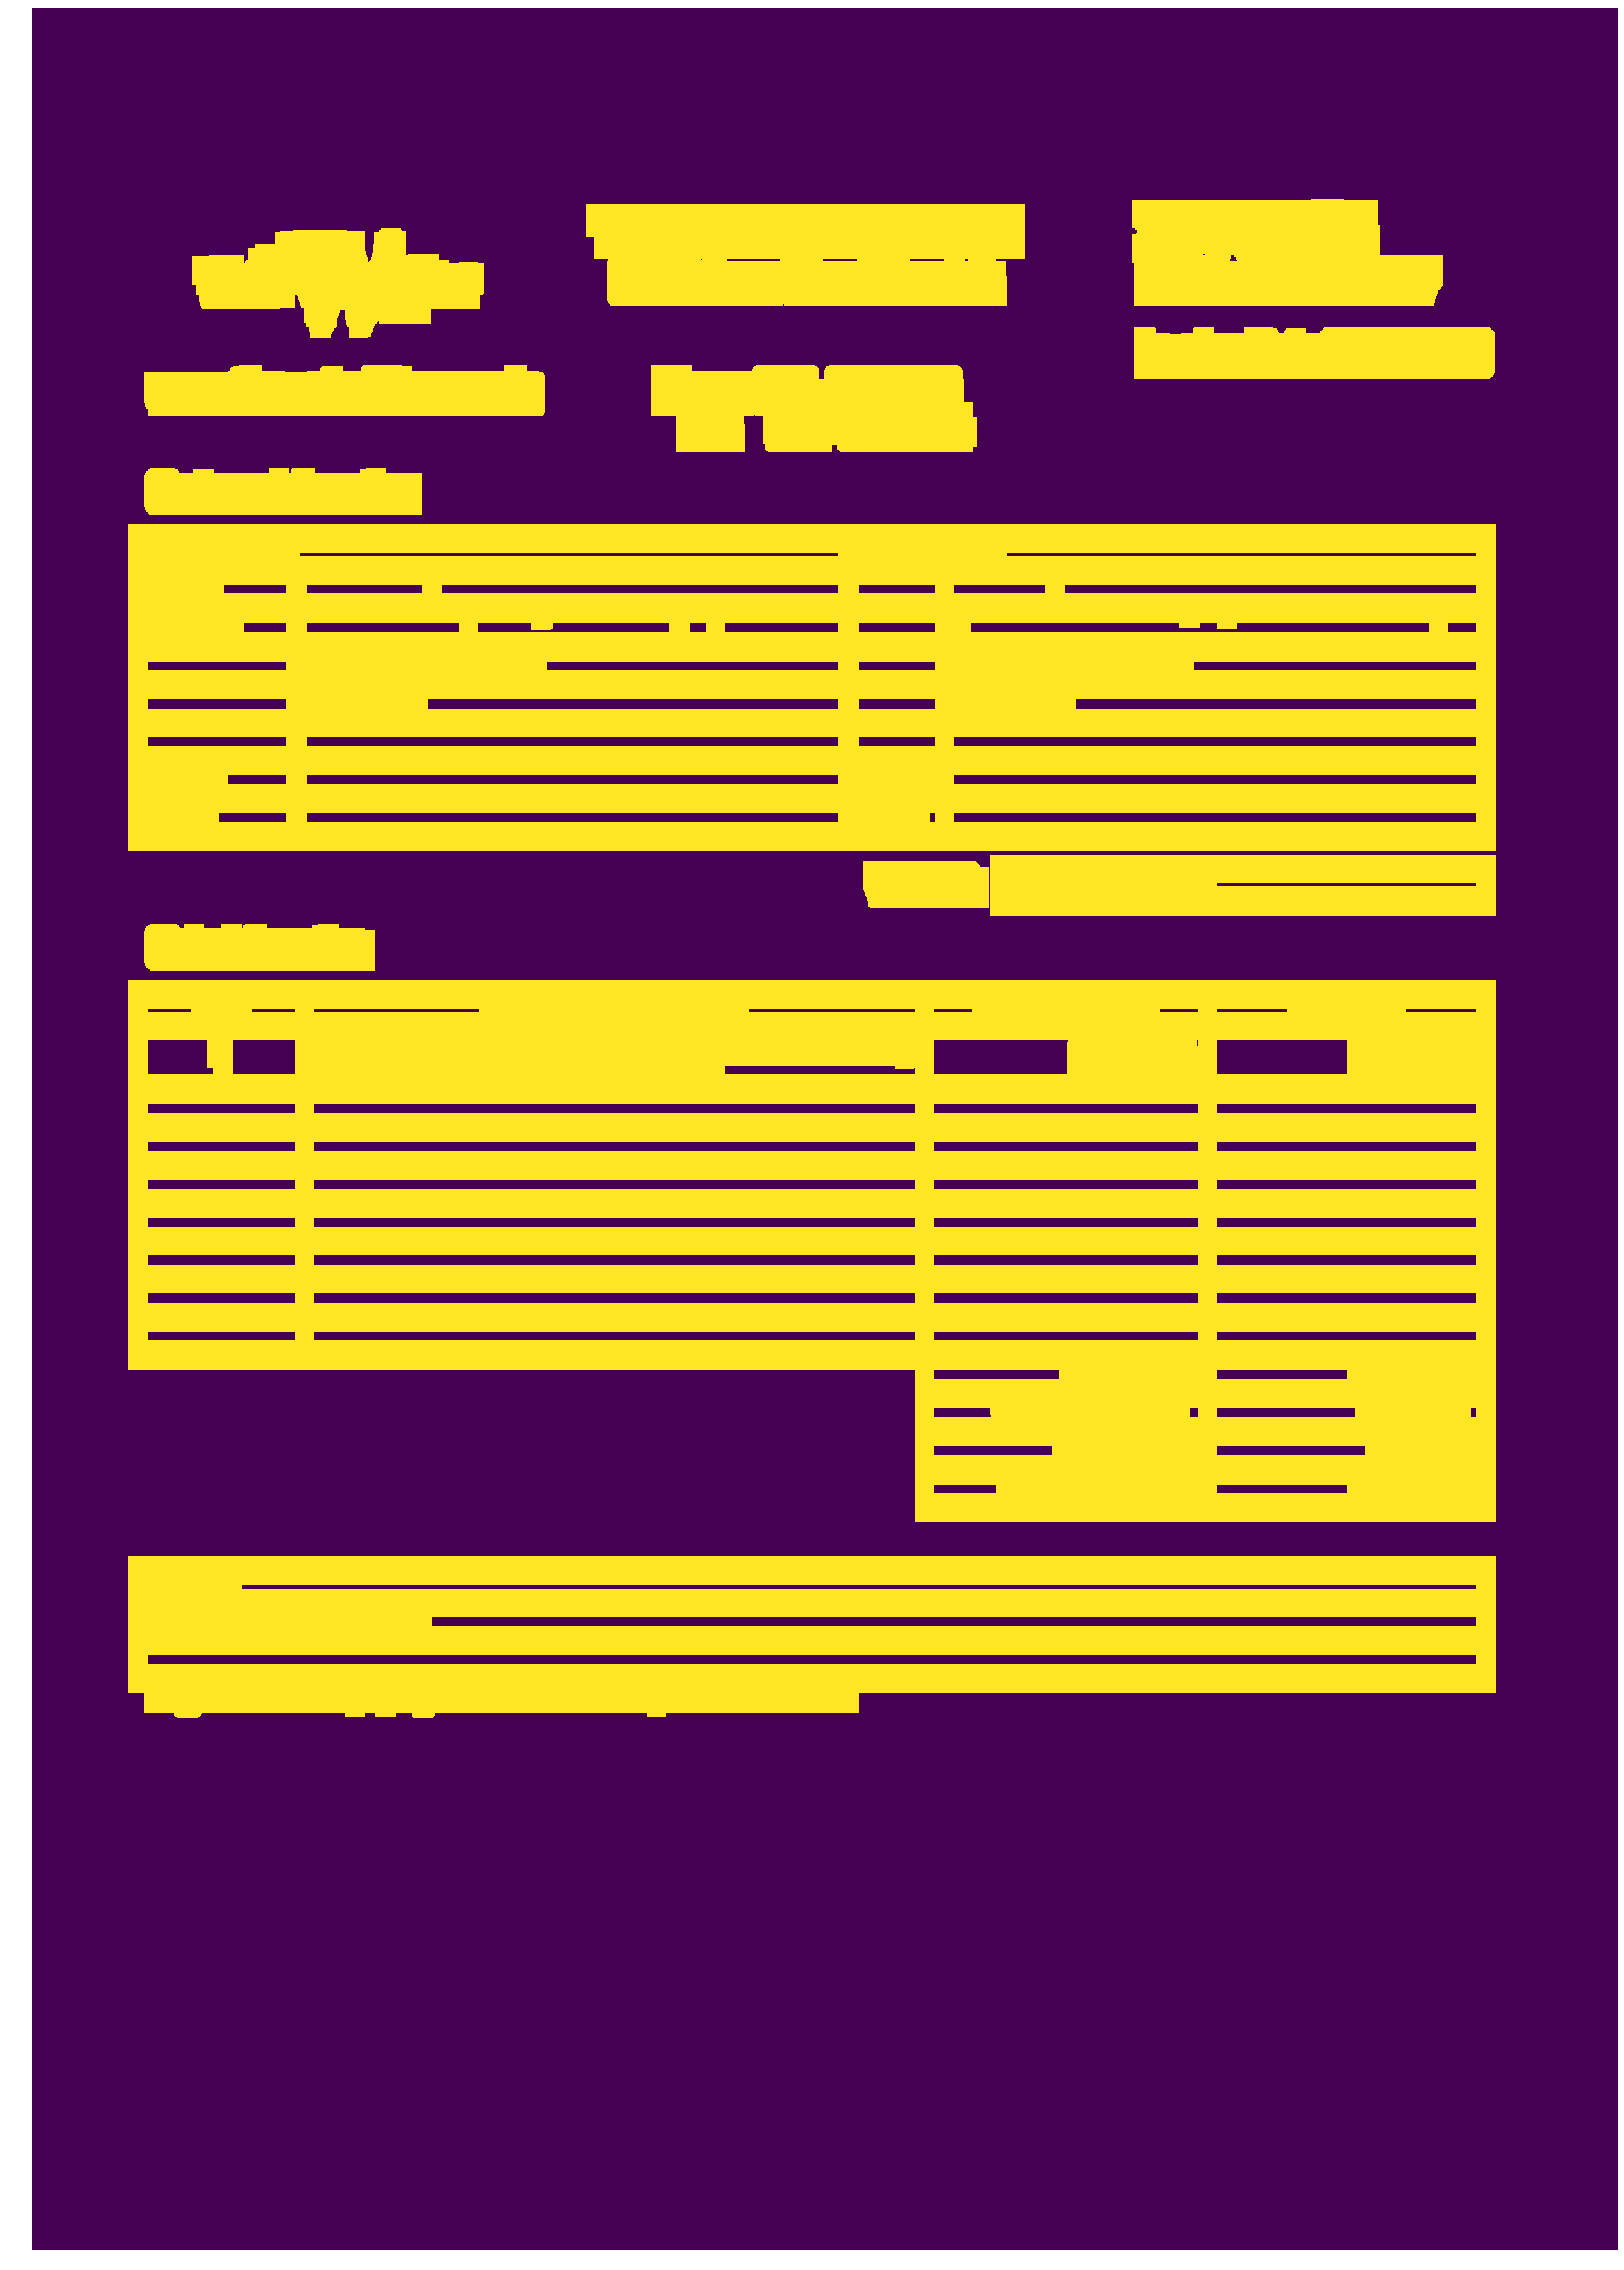

In [21]:
import matplotlib.pyplot as plt
# set size
plt.figure(figsize=(50,50))
plt.axis("off")

plt.imshow(dilation)
plt.show()

### Recherche de contours :

cv2.findContours()est utilisé pour trouver des contours dans l'image dilatée. Il y a trois arguments dans cv.findContours() : l'image source, le mode de récupération de contour et la méthode d'approximation de contour.
Cette fonction renvoie les contours et la hiérarchie. Contours est une liste python de tous les contours de l'image. Chaque contour est un tableau Numpy de coordonnées (x, y) de points limites dans l'objet. Les contours sont généralement utilisés pour trouver un objet blanc sur un fond noir. Toutes les techniques de traitement d'image ci-dessus sont appliquées afin que les Contours puissent détecter les bords limites des blocs de texte de l'image. Un fichier texte est ouvert en écriture et vidé. Ce fichier texte est ouvert pour enregistrer le texte de la sortie de l'OCR.

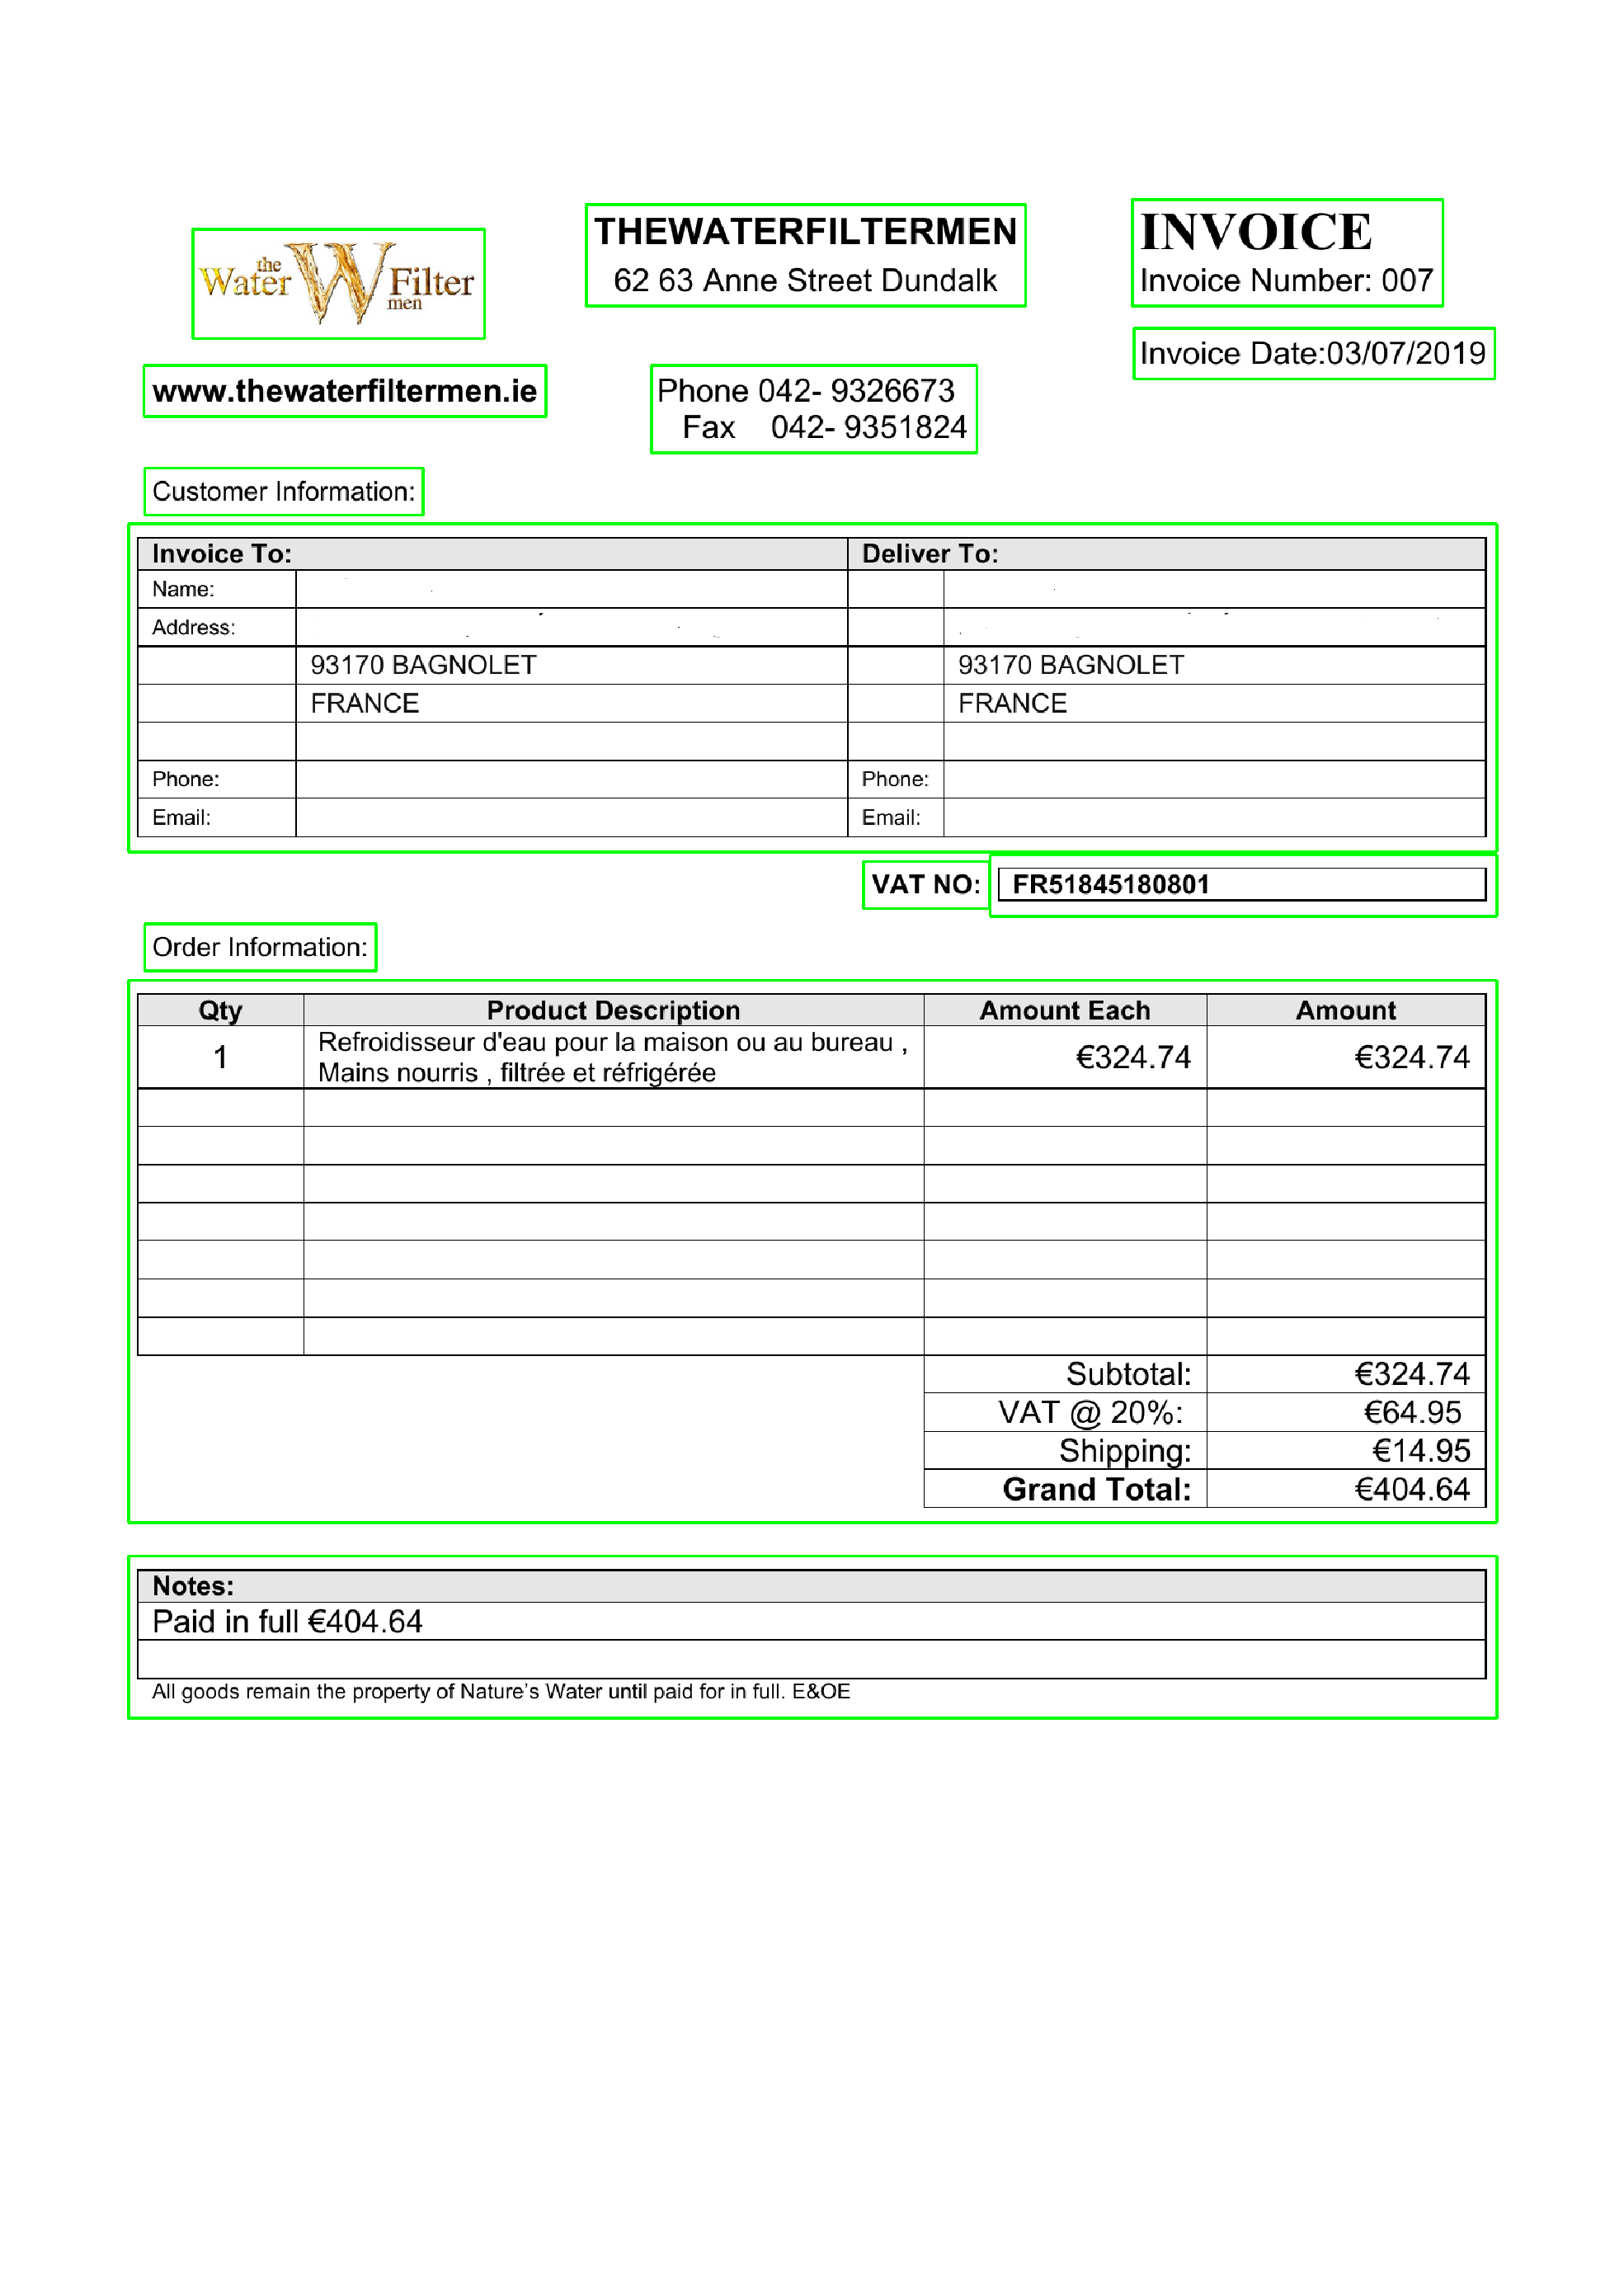

In [22]:
# Finding contours
contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL, 
                                                 cv2.CHAIN_APPROX_NONE)
# Creating a copy of image
im2 = img.copy()
  
# Looping through the identified contours
# Then rectangular part is cropped and passed on
# to pytesseract for extracting text from it
# Extracted text is then written into the text file
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
      
    # Drawing a rectangle on copied image
    rect = cv2.rectangle(im2, (x, y), (x + w, y + h), (0, 255, 0), 2)

import matplotlib.pyplot as plt
# set size
plt.figure(figsize=(50,50))
plt.axis("off")

plt.imshow(im2)
plt.show()

## Détection de block de texte avec OpenCV et hdbscan

Dans cette partie, on vas essayer de Segmenter le texte de l'image, en détectant les coins et caractéristiques de l'image à l'aide du FAST(Features from Accelerated Segment Test) et
et Regroupement des coins à l'aide de HDBSCAN

## DBSCAN
DBSCAN (Density-based Spatial Clustering of Applications with Noise) est un algorithme de clustering de données.
DBSCAN est très polyvalent, il peut trouver des clusters de forme arbitraire et même des clusters internes.
## HDBSCAN
HDBSCAN est un algorithme de clustering développé par Campello, Moulavi et Sander . Il étend DBSCAN en le convertissant en un algorithme de clustering hiérarchique, puis en utilisant une technique pour extraire un clustering plat basé sur la stabilité des clusters.

## FAST (Features from Accelerated Segment Test)
est une méthode de détection de coin, qui pourrait être utilisée pour extraire des points caractéristiques et utilisée plus tard pour suivre et cartographier des objets dans de nombreuses tâches de vision par ordinateur.

Pour commencer, nous suivons les mêmes étapes de traitement d'image.

In [163]:
# Import required packages
import cv2
# Read image from which text needs to be extracted
img = cv2.imread(r'C:\DEV\Table_Detection\data\fact230001-1.png')
# Convert the image to gray scale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

Ensuite, vous devez supprimer toutes les lignes verticales et horizontales, le but est de ne garder que le texte dans l'image
##### Remarque:
        pour les tableaux il vaut mieux les détecter séparément, vous pouvez vous référer à mon article président

In [164]:
def find_lines(
    threshold, regions=None, direction="horizontal", line_scale=15, iterations=0
):
    """Finds horizontal and vertical lines by applying morphological
    transformations on an image.
    Parameters
    ----------
    threshold : object
        numpy.ndarray representing the thresholded image.
    regions : list, optional (default: None)
        List of page regions that may contain tables of the form x1,y1,x2,y2
        where (x1, y1) -> left-top and (x2, y2) -> right-bottom
        in image coordinate space.
    direction : string, optional (default: 'horizontal')
        Specifies whether to find vertical or horizontal lines.
    line_scale : int, optional (default: 15)
        Factor by which the page dimensions will be divided to get
        smallest length of lines that should be detected.
        The larger this value, smaller the detected lines. Making it
        too large will lead to text being detected as lines.
    iterations : int, optional (default: 0)
        Number of times for erosion/dilation is applied.
        For more information, refer `OpenCV's dilate <https://docs.opencv.org/2.4/modules/imgproc/doc/filtering.html#dilate>`_.
    Returns
    -------
    dmask : object
        numpy.ndarray representing pixels where vertical/horizontal
        lines lie.
    lines : list
        List of tuples representing vertical/horizontal lines with
        coordinates relative to a left-top origin in
        image coordinate space.
    """
    lines = []

    if direction == "vertical":
        size = threshold.shape[0] // line_scale
        el = cv2.getStructuringElement(cv2.MORPH_RECT, (1, size))
    elif direction == "horizontal":
        size = threshold.shape[1] // line_scale
        el = cv2.getStructuringElement(cv2.MORPH_RECT, (size, 1))
    elif direction is None:
        raise ValueError("Specify direction as either 'vertical' or 'horizontal'")

    if regions is not None:
        region_mask = np.zeros(threshold.shape)
        for region in regions:
            x, y, w, h = region
            region_mask[y : y + h, x : x + w] = 1
        threshold = np.multiply(threshold, region_mask)

    threshold = cv2.erode(threshold, el)
    threshold = cv2.dilate(threshold, el)
    dmask = cv2.dilate(threshold, el, iterations=iterations)

    try:
        _, contours, _ = cv2.findContours(
            threshold.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )
    except ValueError:
        # for opencv backward compatibility
        contours, _ = cv2.findContours(
            threshold.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )

    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        x1, x2 = x, x + w
        y1, y2 = y, y + h
        if direction == "vertical":
            lines.append(((x1 + x2) // 2, y2, (x1 + x2) // 2, y1))
        elif direction == "horizontal":
            lines.append((x1, (y1 + y2) // 2, x2, (y1 + y2) // 2))

    return dmask, lines

In [165]:
import numpy as np
threshold_inv = cv2.adaptiveThreshold(
            np.invert(gray),
            255,
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY,
            15,
            -2,
        )
vertical_mask, vertical_segments = find_lines(
                threshold_inv,
                regions=None,
                direction="vertical",
                line_scale=15,
                iterations=0,
            )
horizontal_mask, horizontal_segments = find_lines(
    threshold_inv,
    regions=None,
    direction="horizontal",
    line_scale=15,
    iterations=0,
)

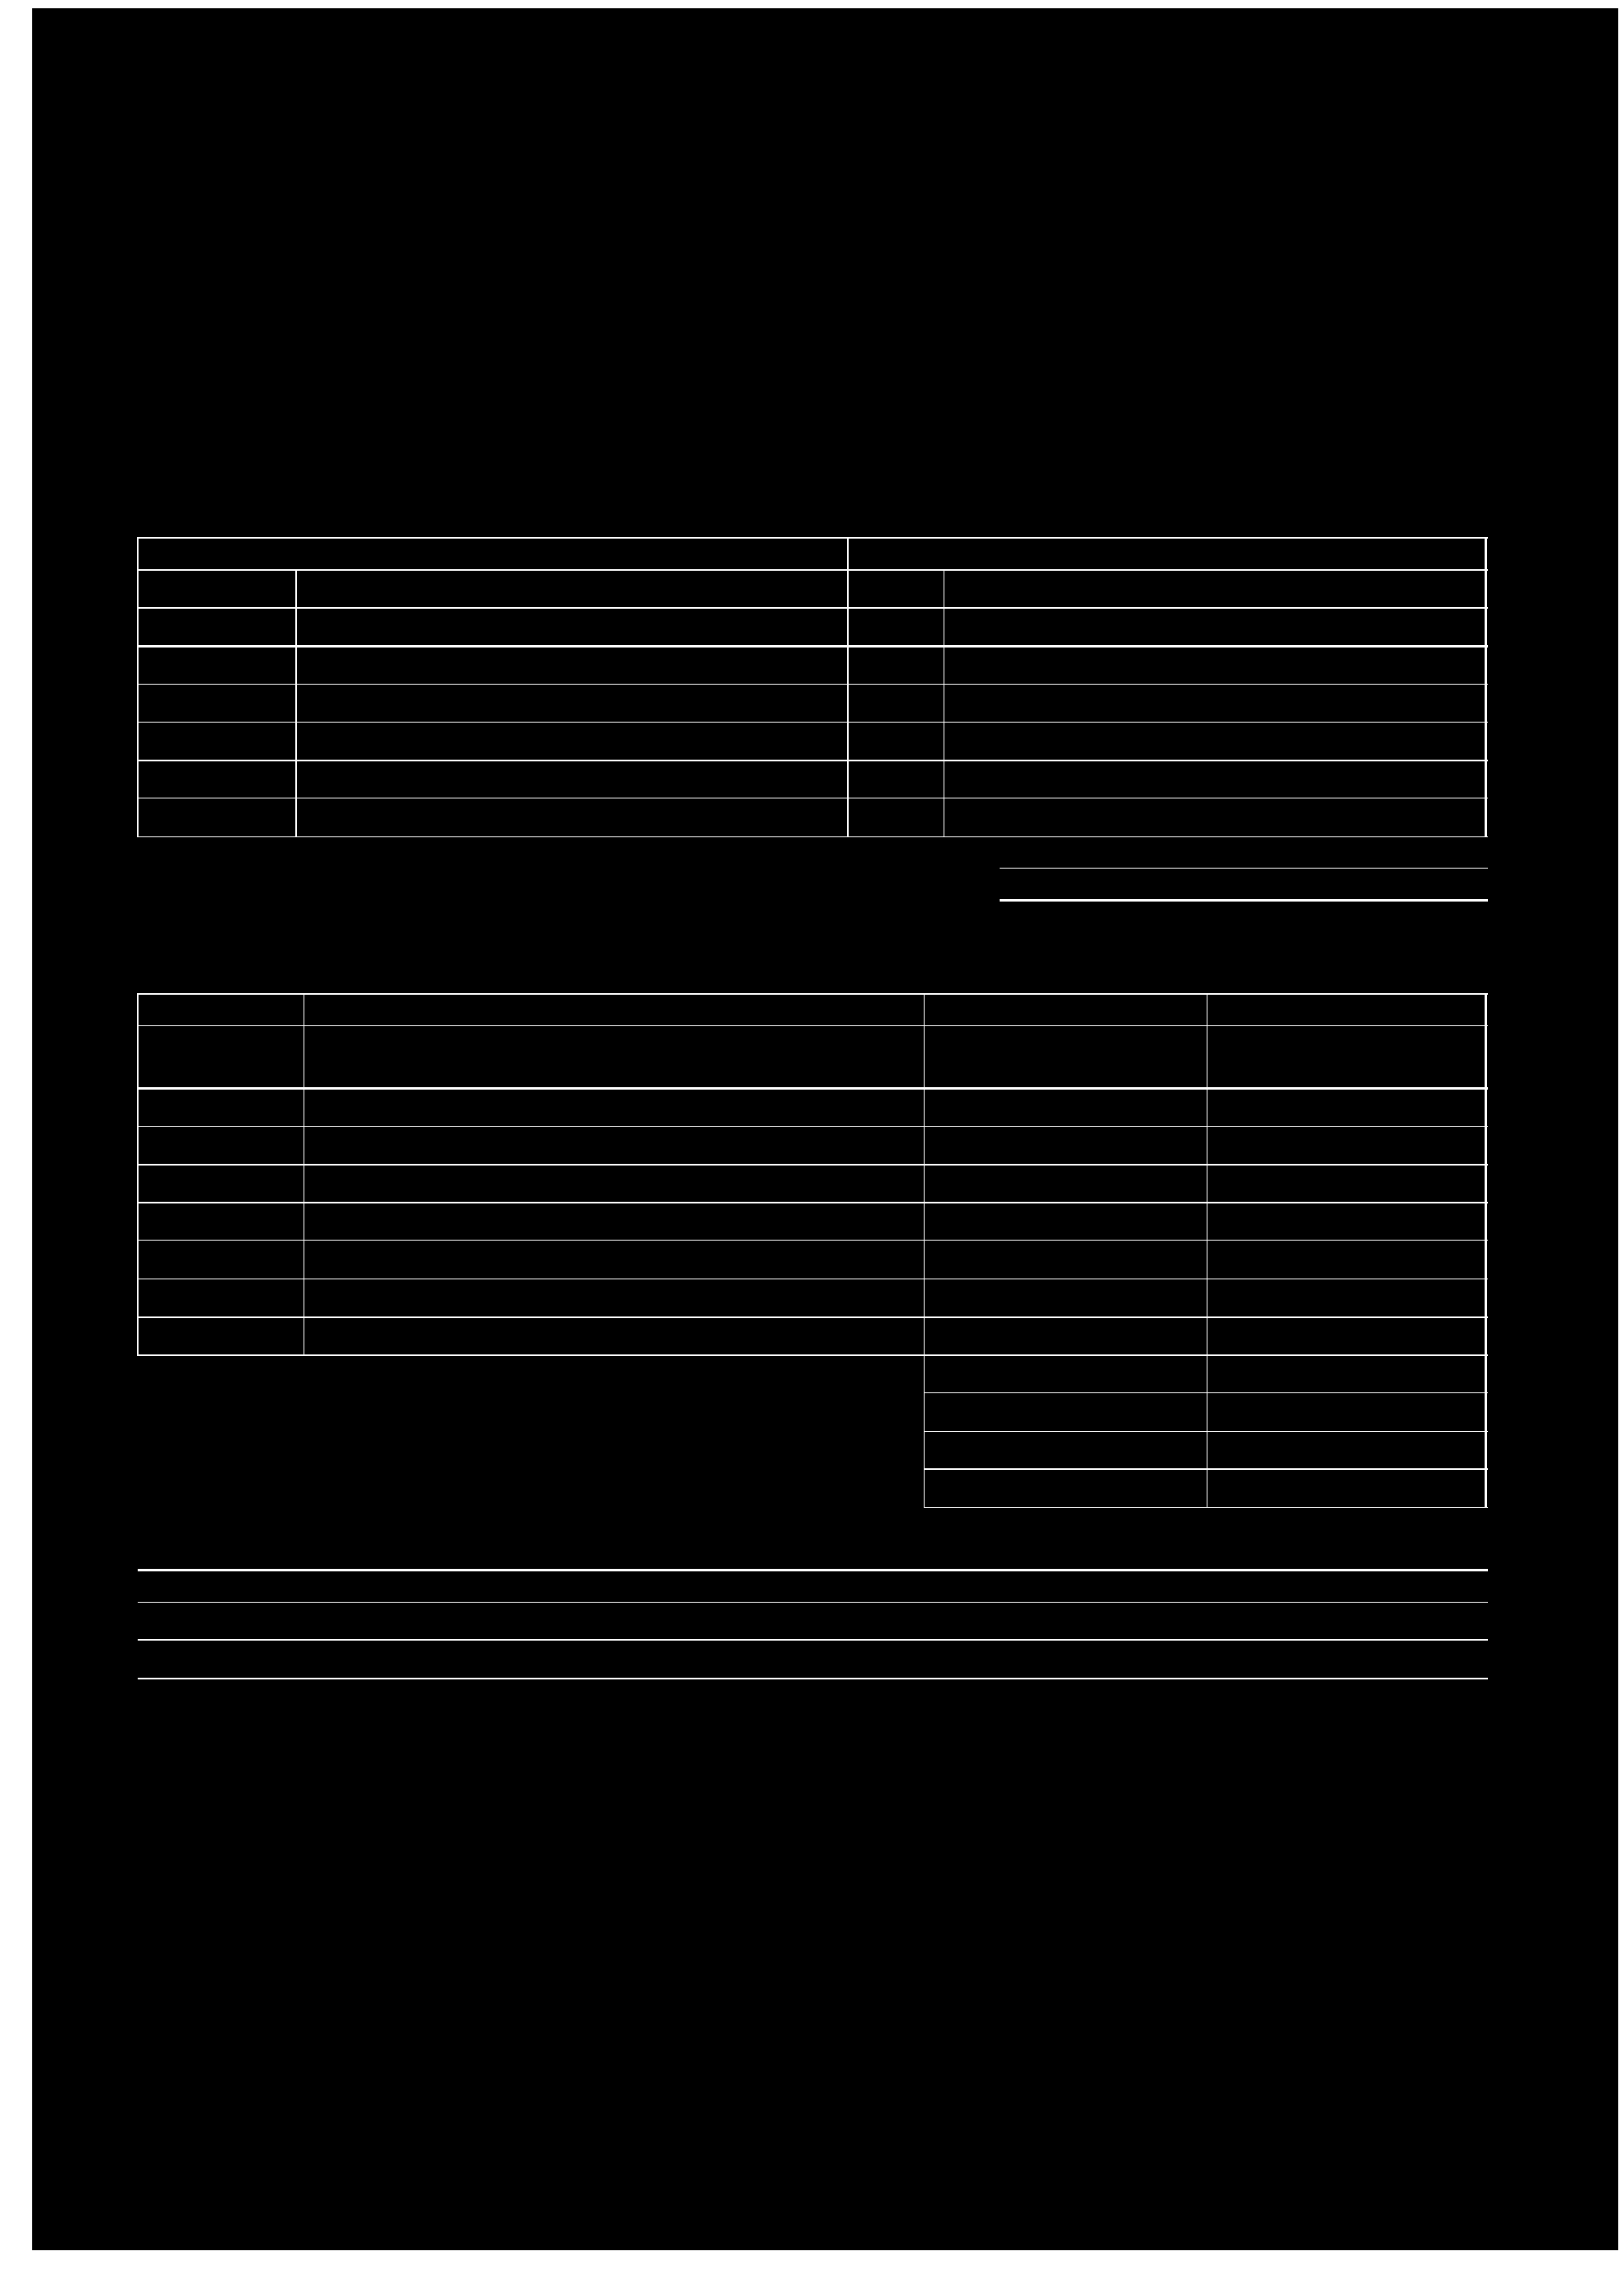

In [166]:
import matplotlib.pyplot as plt
# set size
plt.figure(figsize=(50,50))
plt.axis("off")

plt.imshow(cv2.cvtColor(horizontal_mask+ vertical_mask,cv2.COLOR_BGR2RGB))
plt.show()

In [167]:
def remove_lines(image):
    lines = vertical_mask + horizontal_mask
    kernel = np.ones((5, 5), np.uint8)  # note this is a horizontal kernel
    lines = cv2.dilate(lines, kernel, iterations=2)
    image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    image = cv2.bitwise_or(image, lines, mask=None)
    return image

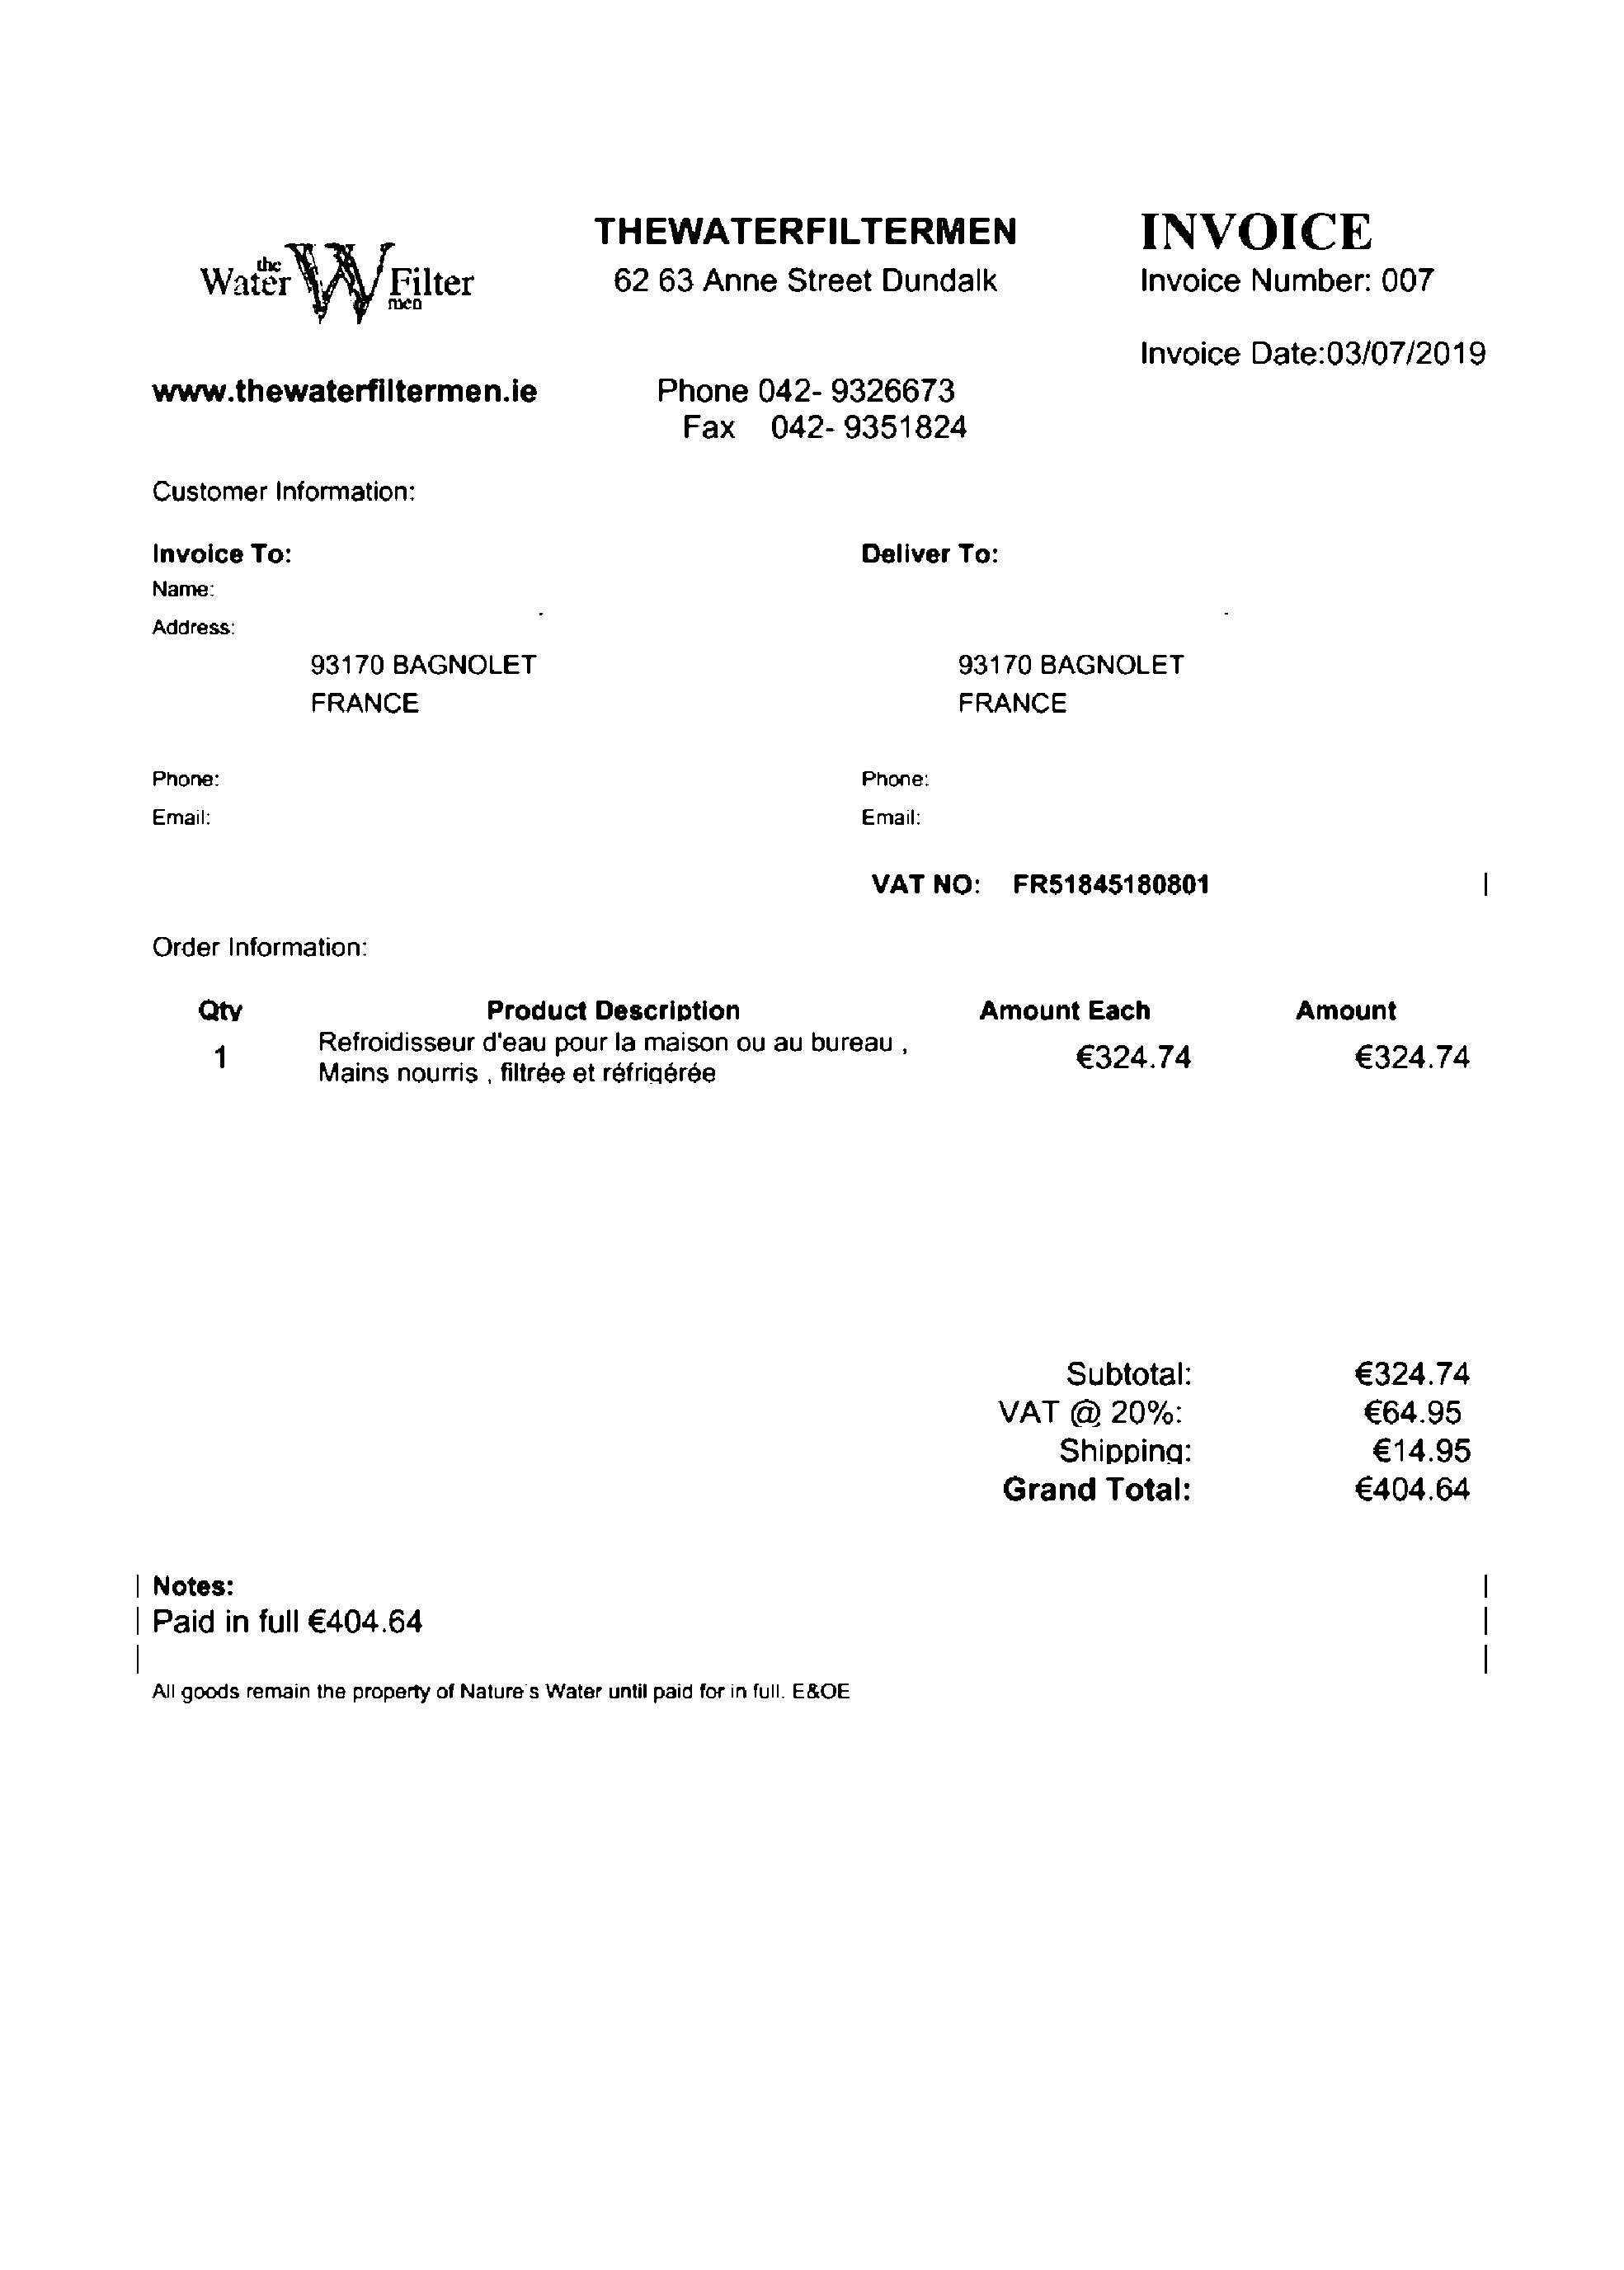

In [168]:
image_remove_ligne = remove_lines(thresh)
import matplotlib.pyplot as plt
# set size
plt.figure(figsize=(50,50))
plt.axis("off")

plt.imshow(cv2.cvtColor(image_remove_ligne,cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
Dans cet partie nous allons appliquer l'algoritheme Accelerated Segment Test (FAST) dans le but de recuper les postions de text dans l'image

In [169]:
def findCorners(image):
    """
    features from Accelerated Segment Test (FAST) Corner detection
    :parm image:
    : retrun array[[x1,y1],[x2,y2]
    """
    pos_corners = []
    pos_corners_xy = []
    
    fast = cv2.FastFeatureDetector_create()
    kp = fast.detect(image, None)
    w = 1
    h = 1
    for cnt in kp:
        x, y = cnt.pt
        pos_corners.append([x, y, x+w, y+h])
        pos_corners_xy.append([x, y])
    return pos_corners, pos_corners_xy, kp

In [170]:
pos_corners, pos_corners_xy, kp = findCorners(image_remove_ligne) 
thresh_inv = 255-image_remove_ligne
contours, hierarchy = cv2.findContours(thresh_inv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

In [171]:
img2 = image_remove_ligne.copy()
img2 = cv2.drawKeypoints(img2, kp, None, color=(255,0,0))
for cnt in contours:
    
    """
    +-----+-----+
    |           |
    +     +     + 
    |           |
    +-----+-----+    
    """
    
    x, y, w, h = cv2.boundingRect(cnt)
    
    pos_corners.append([x, y, x+w, y+h])
    pos_corners_xy.append([x, y])
    
    pos_corners.append([x, y, x+w, y+h])
    pos_corners_xy.append([x+w, y+h])
    
    pos_corners.append([x, y, x+w, y+h])
    pos_corners_xy.append([x+w, y])
    
    pos_corners.append([x, y, x+w, y+h])
    pos_corners_xy.append([x, y+h])
    
    pos_corners.append([x, y, x+w, y+h])
    pos_corners_xy.append([x+w/2, y+h/2])
    
    pos_corners.append([x, y, x+w, y+h])
    pos_corners_xy.append([x, y+h/2])
    
    pos_corners.append([x, y, x+w, y+h])
    pos_corners_xy.append([x+w/2, y])
    
    
    pos_corners.append([x, y, x+w, y+h])
    pos_corners_xy.append([x+w, y+h/2])
    
    pos_corners.append([x, y, x+w, y+h])
    pos_corners_xy.append([x+w/2, y+h])


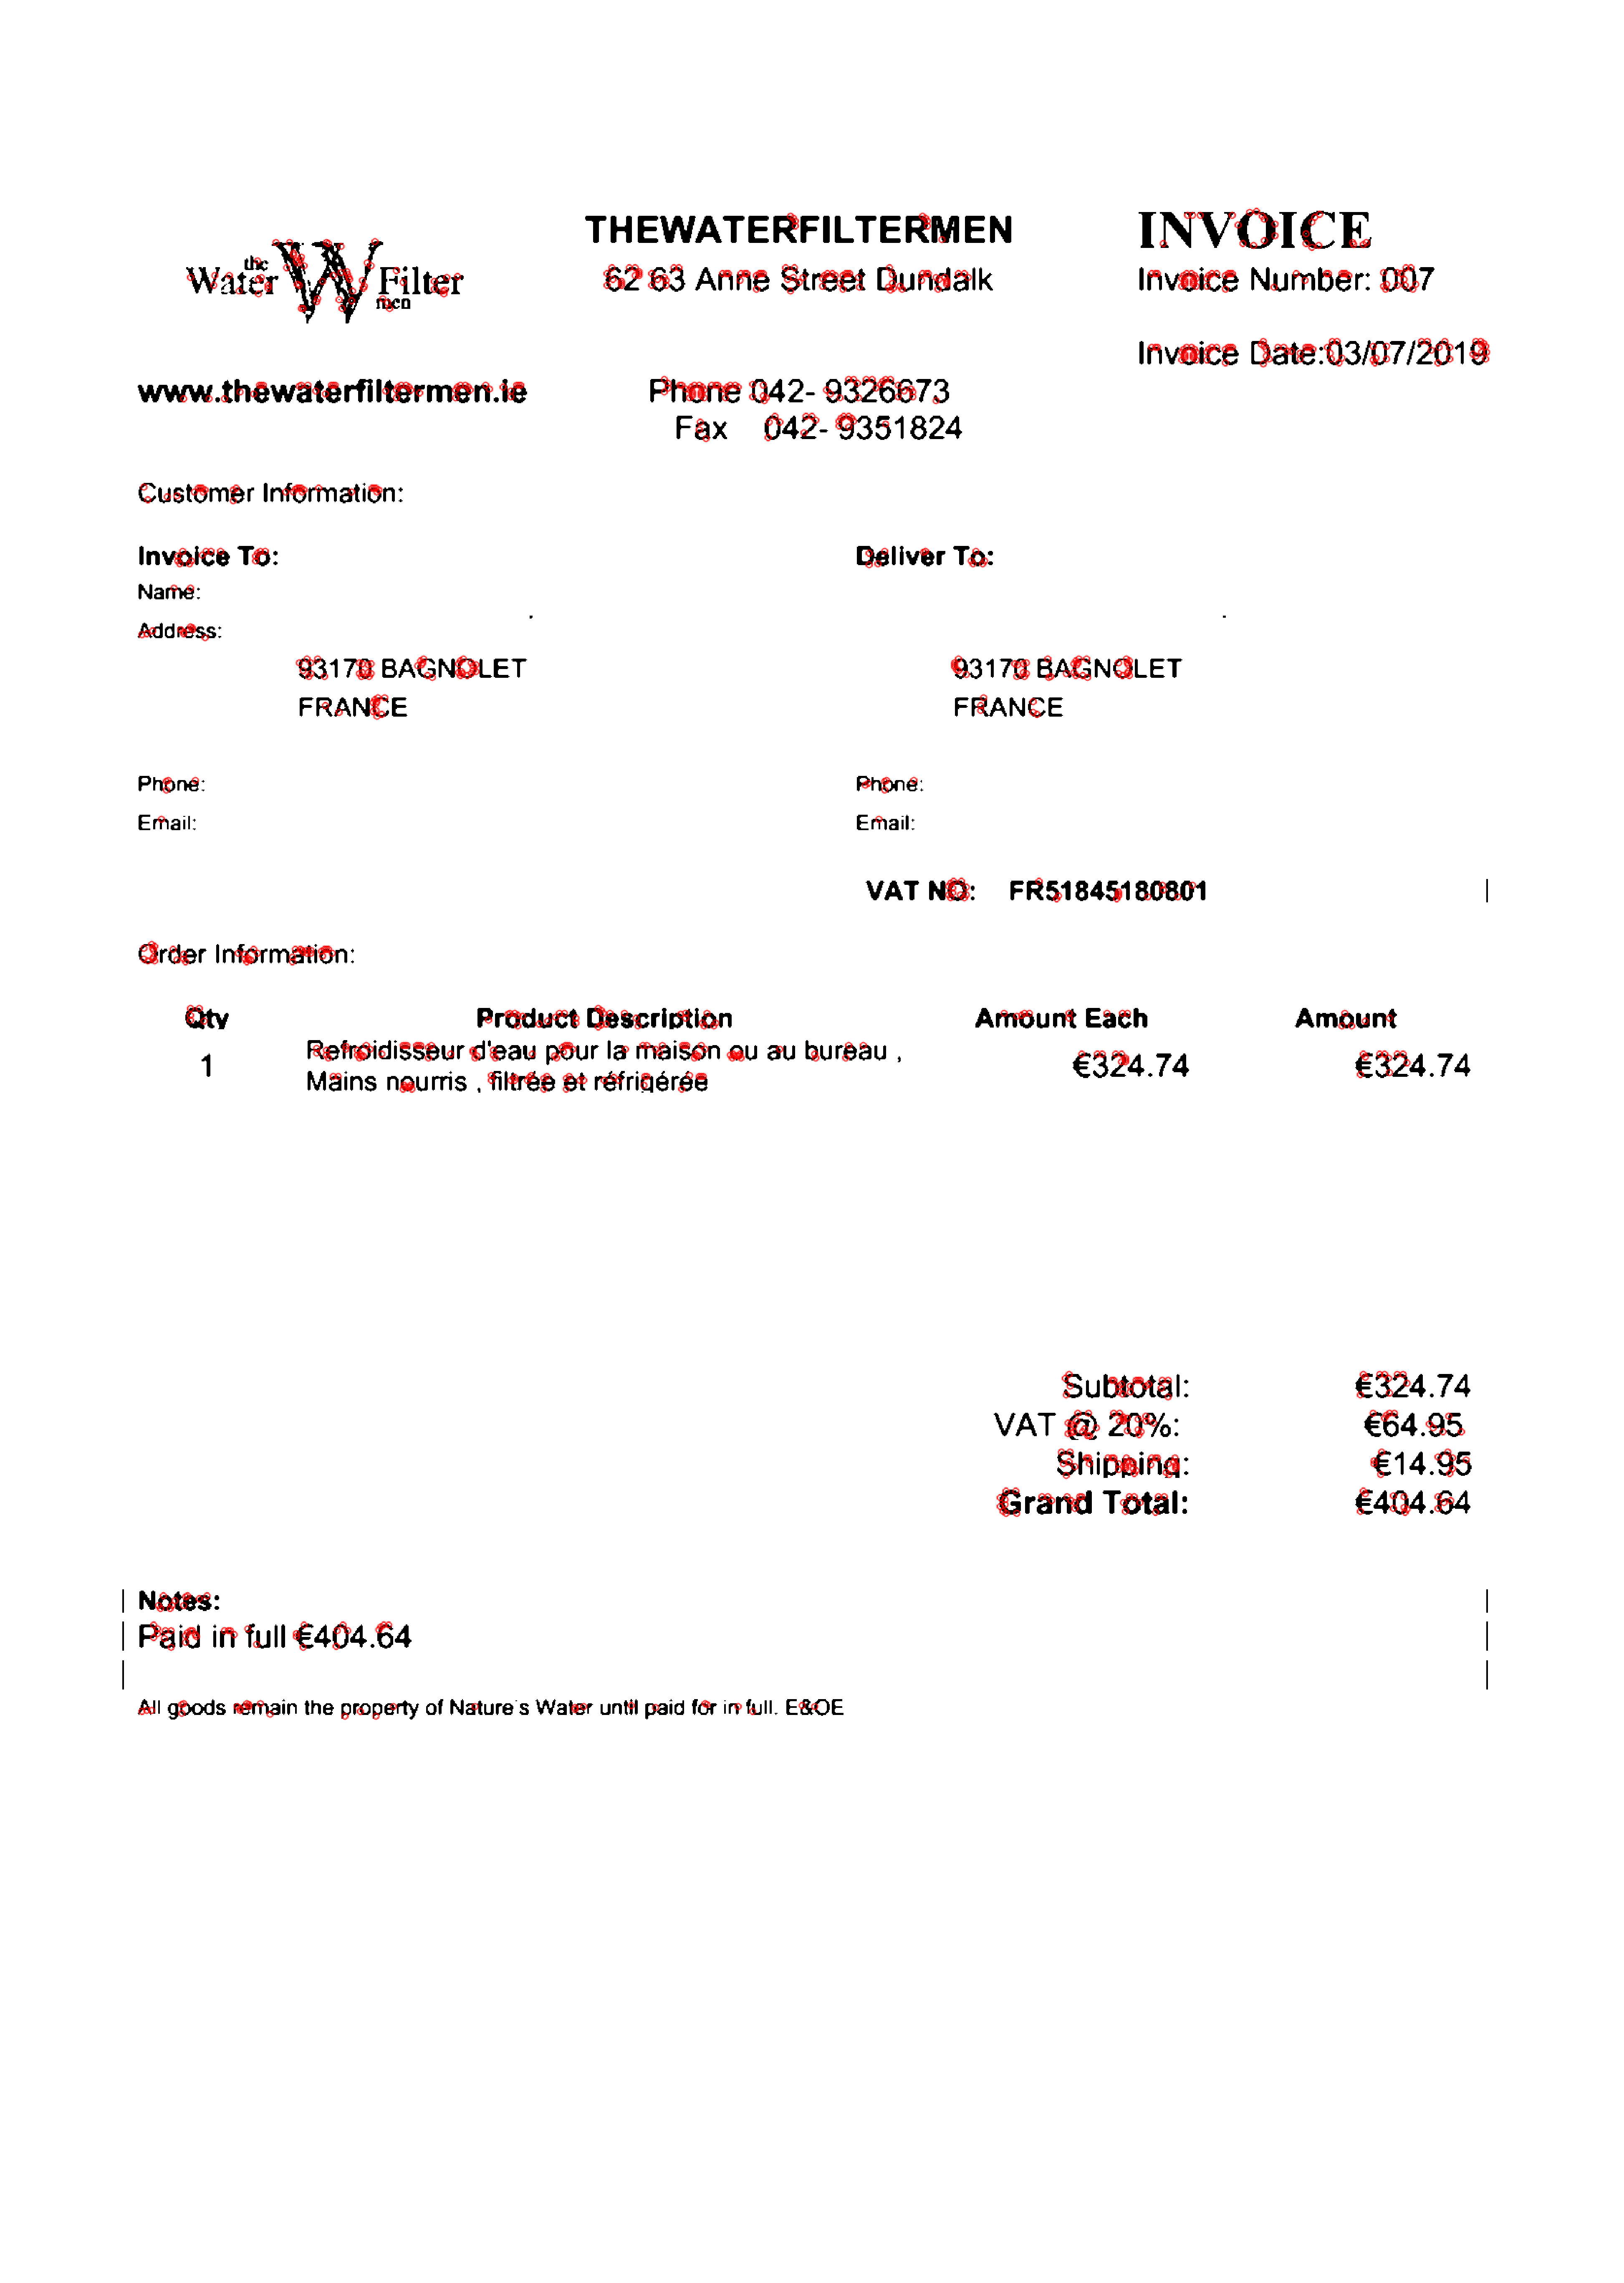

In [172]:
import matplotlib.pyplot as plt
# set size
plt.figure(figsize=(100,100))
plt.axis("off")

plt.imshow(img2)
plt.show()

l'étape suivante consiste à appliquer dbscan pour regrouper les zones de texte les plus proches en blocs de texte

In [173]:
import numpy as np
data_hdbsan = np.array(pos_corners_xy)
height = max(data_hdbsan[:, 1]) - min(data_hdbsan[:, 1])
width = max(data_hdbsan[:, 0]) - min(data_hdbsan[:, 0])
data_hdbsan[:, 0] = data_hdbsan[:, 0]/width
data_hdbsan[:, 1] = data_hdbsan[:, 1]/height

In [152]:
import hdbscan

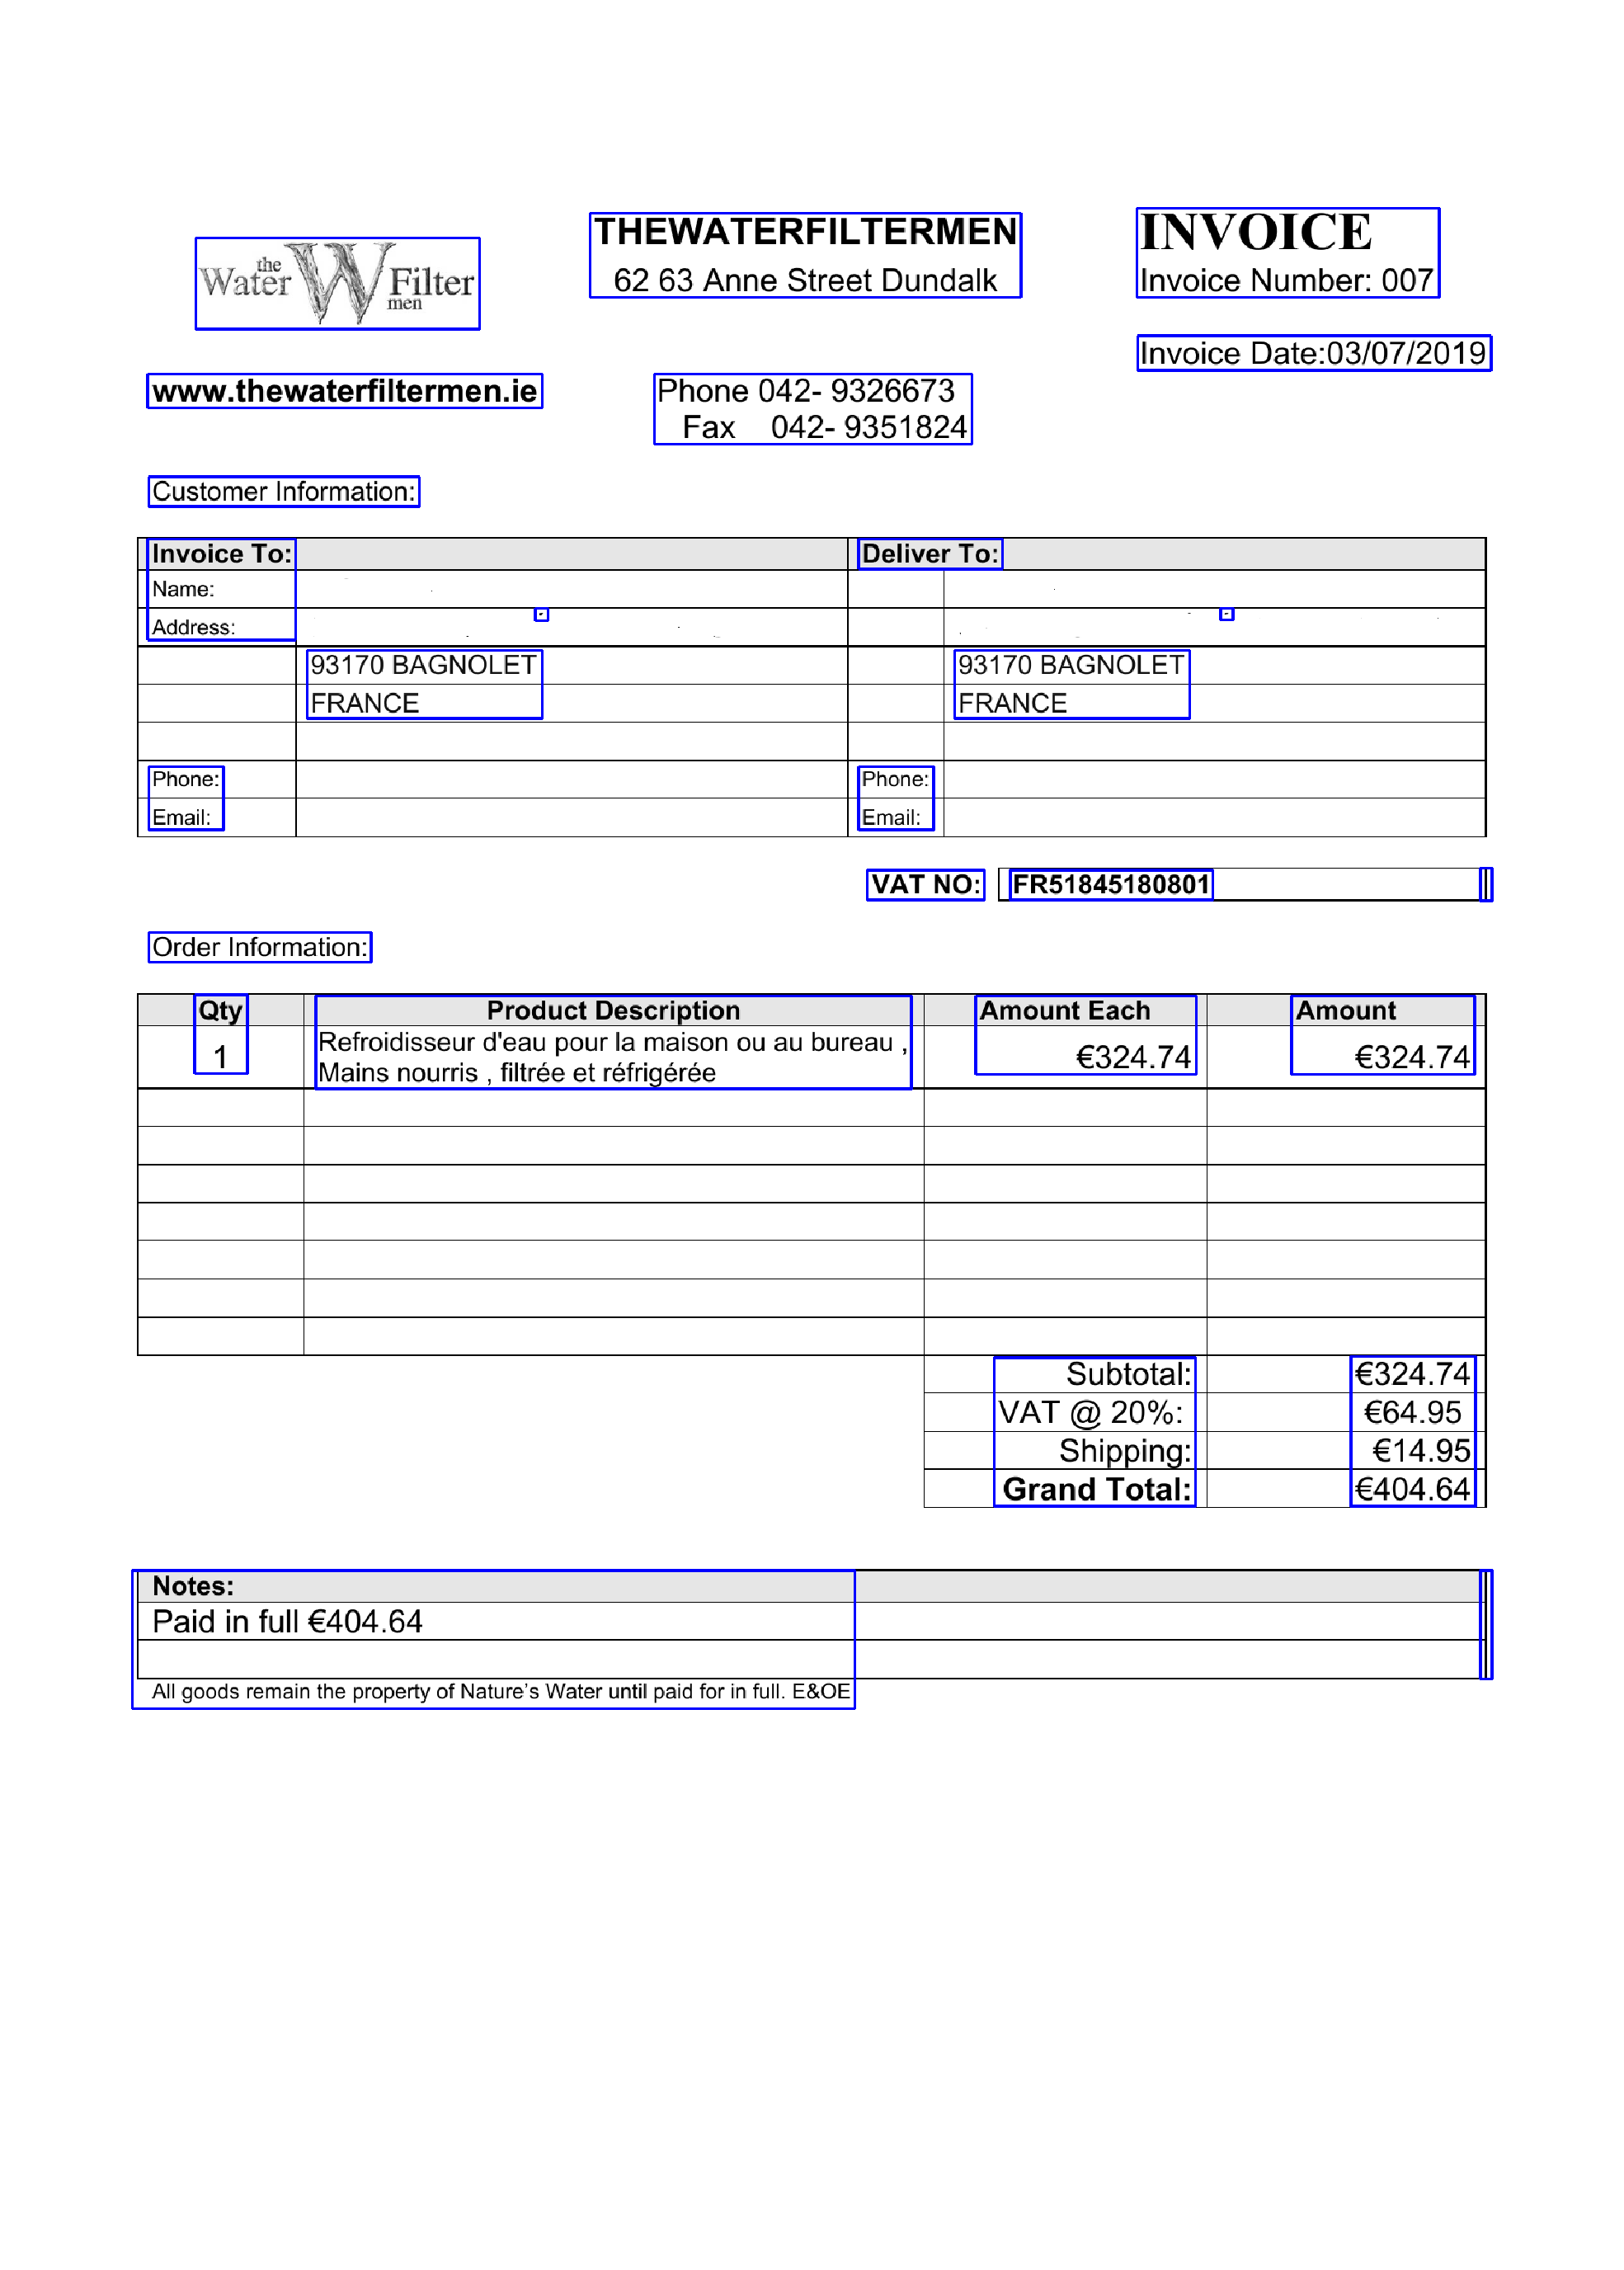

In [197]:
hdb = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=5, cluster_selection_epsilon=0.025)
hdb.fit (data_hdbsan)
n_clusters = len(set(hdb.labels_)) - (1 if -1 in hdb.labels_ else 0 )
pos_corners = np.array(pos_corners)
rects = {}
for i in range(n_clusters):
    group = pos_corners[hdb.labels_ == i]
    rects[i] = group
def merge_boxes(boxes):
    for key in boxes.keys():
        box = boxes[key]
        if len(box) > 0:
            new_pos = [max(0, min(box[:, 0]-5)), max(0, min(box[:, 1]-5)), max(box[:, 2]+5), max(box[:, 3]+5)]
            boxes[key] = new_pos
    return boxes
mer_boxes = merge_boxes(rects)
img3 = gray.copy()
img3 = cv2.cvtColor(img3,cv2.COLOR_BGR2RGB)
for box in mer_boxes.values():
    cv2.rectangle(img3, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])),(0, 0, 255), 2)
import matplotlib.pyplot as plt
# set size
plt.figure(figsize=(50,50))
plt.axis("off")

plt.imshow(img3)
plt.show()

Dans cet article, nous avons introduit une approche simple de segmentation de texte qui fonction dans le cas de block bien séparées, cex deux approche simple serait suffisante.
Cependant, il existe également des pages plus compliquées avec des irrégularités où la détermination des block est compliquée, dnas ce cas je vous suggère d'utiliser des méthodes de segmentation qui sont basées sur des réseaux entièrement convolutifs



* https://jfbarryli.github.io/ITSegmenter/
* https://docs.opencv.org/4.5.2/d9/d61/tutorial_py_morphological_ops.html